# Machine Learning Project

__Pia CHANCEREL - Raphael LASRY - Maxime POLI__

Based on the article :

_A Continuation Method for Semi-Supervised SVMs_

Olivier Chapelle $\hspace{3.9cm}$ olivier.chapelle@tuebingen.mpg.de

Mingmin Chi $\hspace{4.5cm}$ mingmin.chi@tuebingen.mpg.de

Alexander Zien $\hspace{4.1cm}$ alexander.zien@tuebingen.mpg.de


Max Planck Institute for Biological Cybernetics, Tübingen, Germany

https://dl.acm.org/doi/pdf/10.1145/1143844.1143868?download=true

In [9]:
import numpy as np
import scipy as sc
import pandas as pd
from tqdm import tqdm
import time as time
import matplotlib.pyplot as plt

# 20newsgroup

20newsgroup dataset: https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html

Dataset of an old forum. We will only focus on messages related to windows and mac. The goal is to predict the subject of the message (windows or mac) thanks to a $S^3VM$ method.

In [10]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import PolynomialFeatures

# print(newsgroups_train.DESCR) # Documentation of how to use the dataset

In [11]:
cat = ['comp.sys.mac.hardware', 'comp.os.ms-windows.misc']
# cat = ['sci.crypt', 'sci.electronics']
newsgroups_train = fetch_20newsgroups(subset = 'train', categories = cat) 
newsgroups_test = fetch_20newsgroups(subset = 'test', categories = cat) 

print('training set')
print('posts', newsgroups_train.filenames.shape) # Text, content of the messages
print('class', newsgroups_train.target.shape) # In which categories the message should be classified
print('test set')
print('posts', newsgroups_test.filenames.shape)
print('class', newsgroups_test.target.shape)

training set
posts (1169,)
class (1169,)
test set
posts (779,)
class (779,)


In [12]:
# Converting text to vectors
vectorizer = TfidfVectorizer(encoding='latin1')
# Pas sûr de ma solution mais ça a l'air d'être ça
vectorizer.fit(newsgroups_train.data+newsgroups_test.data) # From a text message to a sparse matrix
vectors_train = vectorizer.transform(newsgroups_train.data)
vectors_test = vectorizer.transform(newsgroups_test.data)
print(vectors_train.shape)
print(vectors_test.shape)

(1169, 64711)
(779, 64711)


In [13]:
# Nombre moyen de features non nulles
vectors_test.nnz/float(vectors_test.shape[0])

134.997432605905

In [14]:
#print(vectors_train) # Sparse matrix. The first index is the index of the message and the second ones are the indexes whithin this matrix where the value isn't a 0.

# House Data

In [15]:
# récupération des données
data = pd.read_csv('data.csv')
data['date_int'] = pd.to_datetime(data['date']).dt.strftime("%Y%m%d").astype(int)
city = pd.get_dummies(pd.Categorical(data['city']), prefix='city')
X_housedata = np.concatenate([data[['date_int', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']].to_numpy(), city.to_numpy()], axis=1)
Y_housedata = data['price'].to_numpy()

# séparation train, val, test
r = np.random.permutation(len(X_housedata))
X_train = X_housedata[r[0:3500], :]
Y_train = Y_housedata[r[0:3500]]
X_val = X_housedata[r[3500:4000], :]
Y_val = Y_housedata[r[3500:4000]]
X_test = X_housedata[r[4000:], :]
Y_test = Y_housedata[r[4000:]]

# standardisation
X_train = (X_train - np.mean(X_train, axis = 0)) / (np.std(X_train, axis = 0) + 10 ** (-15))
X_val = (X_val - np.mean(X_val, axis = 0)) / (np.std(X_val, axis = 0) + 10 ** (-15))
X_test = (X_test - np.mean(X_test, axis = 0)) / (np.std(X_test, axis = 0) + 10 ** (-15))

# séparation en 2 classes
Y_train = 2 * np.array(np.array(Y_train) - np.median(Y_train) > 0).astype(int) - 1
Y_val = 2 * np.array(np.array(Y_val) - np.median(Y_val) > 0).astype(int) - 1
Y_test = 2 * np.array(np.array(Y_test) - np.median(Y_test) > 0).astype(int) - 1

# S3VM

In [16]:
# test de multiplication
X = np.ones((3, 4))
Y = np.arange(3)
print(X, Y)
print(np.multiply(X.T, Y).T)
print((X.T * Y).T)

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]] [0 1 2]
[[0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [2. 2. 2. 2.]]
[[0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [2. 2. 2. 2.]]


In [17]:
# SAGC (pour débugger)

class Model():
    def __init__(self):
        self.stand = False
        self.norm = False
        self.eigen_vecs = None

    def standardize(self, X):
        return (X - np.mean(X, 0))/(np.std(X,0)+10**(-11))

    def normalize(self, X):
        return X/np.linalg.norm(X, axis=1, keepdims=True)
        
    def orthogonalize(self, X, nb_col):
        assert(np.mean(X)!=0)
        K = np.dot(X.T, X) / len(X)
        _, eigen_vecs = np.linalg.eigh(K)
        self.eigen_vecs = eigen_vecs[:,-nb_col:]
    

class SAGClassifier(Model):
    def __init__(self, lambada=1e-3, eta=1e-2):
        super().__init__()
        self.lambada = lambada
        self.eta = eta
        self.w = None
        self.loss = None # Liste conservant la loss cumulée à chaque époque

        
    def fit(self, X, Y, epochs=5, nb_iter=None, stand=False, norm=False, nb_col=None):
        self.stand = stand
        self.norm = norm
        self.loss = []
        # Traitement des données
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=1)
        if nb_col is None:
            self.eigen_vecs = None
        if self.norm:
            X = self.normalize(X)
        if self.stand:
            X = self.standardize(X)
            if nb_col is not None:
                self.orthogonalize(X, nb_col)
                X = np.dot(X, self.eigen_vecs)
        
        # Implémentation de la SAG
        X = np.hstack((np.ones((X.shape[0], 1)), X)) # Ajoute colonne de 1
        n, m = X.shape
        self.w = np.zeros(m)
        d = np.zeros(m)
        if nb_iter is not None:
            n = min(nb_iter, n)
        gradient = np.zeros((n, m))
        for k in range(epochs):
            r = np.random.permutation(n)
            X, Y, gradient = X[r, :], Y[r], gradient[r, :]
            current_loss = 0
            for i in range(n):
                d -= gradient[i]
                hinge_loss = max(0,1-Y[i]*np.dot(X[i], self.w))
                current_loss += hinge_loss
                gradient[i] = -Y[i]*X[i] if hinge_loss > 0 else np.zeros(m)
                d += gradient[i]
                # L'article n'étant pas clair sur le "number of unique values sampled so far" 
                # et la gestion des époques, je l'ai interprété comme ci-dessous
                count = i+1 if k == 0 else n
                self.w[1:] = (1 - self.eta*self.lambada) * self.w[1:] - self.eta * d[1:]/count
                self.w[0] = self.w[0] - self.eta*d[0]/count
            current_loss = 0.5*self.lambada*np.dot(self.w[1:], self.w[1:]) + current_loss/n
            self.loss.append(current_loss)
    
    
    def predict(self, X):
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=1)
        if self.norm:
            X = self.standardize(X)
        if self.stand:
            X = self.standardize(X)
            if self.eigen_vecs is not None:
                X = np.dot(X, self.eigen_vecs)
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return 2*(np.dot(X,self.w) >= 0) - 1

In [18]:
class S3VMClassifier():
    """
        S3VM class as defined in the article.
    """
    def __init__(self, C=1.0, C_=1.0, lr=0.01, s=3, sparse_data=False):
        self.C = C
        self.C_ = C_
        self.lr = lr
        self.s = s
        self.loss_list = []
        self.sparse_data = sparse_data
        self.X = None
        self.Y = None
        self.X_ = None
        self.w = None
        self.b = None
        
    def compute_gamma(self, epochs):
        """
            Compute the list of values of gamma (defined at the §3.2).
        """
        m, d = self.X_.shape

        if self.sparse_data:
            matrix = sc.sparse.lil_matrix((d, d))
            for i in range(m):
                matrix += self.X_[i].T@self.X_[i] / sc.sparse.linalg.norm(self.X_[i]) ** 3
            lamb_max = np.real(np.sort(sc.sparse.linalg.eigs(matrix, return_eigenvectors=False))[-1])
            gamma_0 = (self.C_ * lamb_max) ** (2 / 3) / (2 * self.s) ** (1 / 3)
            gamma_end = 1 / (epochs * 2 * self.s * sc.sparse.linalg.norm(self.X_, axis=1).max() ** 2)
            
        else:
            matrix = np.zeros((d, d))
            for i in range(m):
                matrix += self.X_[i].T@self.X_[i] / np.linalg.norm(self.X_[i]) ** 3
            lamb_max = np.sort(np.linalg.eigvals(matrix))[- 1]
            gamma_0 = (self.C_ * lamb_max) ** (2 / 3) / (2 * self.s) ** (1 / 3)
            gamma_end = 1 / (epochs * 2 * self.s * np.linalg.norm(self.X_, axis=1).max() ** 2)
            
        gamma_list = [(gamma_end / gamma_0) ** (i / epochs) * gamma_0 for i in range(epochs)]
        return gamma_list
    
    def loss(self, gamma):
        """
            Compute the convolved loss (defined at the end of the §3.1).
        """
        d = self.X.shape[1]
        if self.sparse_data:
            a = 1 + 2 * gamma * self.s * sc.sparse.linalg.norm(self.X_, axis = 1) ** 2
            e = (self.Y * (self.X.dot(self.w) + self.b) - 1) / np.sqrt(2 * gamma) / sc.sparse.linalg.norm(self.X, axis = 1)
            L_labelled = self.C * sc.sparse.csr_matrix.sum(gamma * sc.sparse.linalg.norm(self.X, axis = 1) / np.sqrt(2) 
                                         * (np.exp(- e ** 2) / np.sqrt(np.pi) - e * sc.special.erfc(e)))
            L_unlabelled = self.C_ * sc.sparse.csr_matrix.sum(1 / np.sqrt(a) * np.exp(- self.s * (self.X_.dot(self.w) + self.b) ** 2 / a))

        else:
            a = 1 + 2 * gamma * self.s * np.linalg.norm(self.X_, axis = 1) ** 2
            e = (self.Y * (self.X.dot(self.w) + self.b) - 1) / np.sqrt(2 * gamma) / np.linalg.norm(self.X, axis = 1)
            L_labelled = self.C * np.sum(gamma * np.linalg.norm(self.X, axis = 1) / np.sqrt(2) 
                                         * (np.exp(- e ** 2) / np.sqrt(np.pi) - e * sc.special.erfc(e)))
            L_unlabelled = self.C_ * np.sum(1 / np.sqrt(a) * np.exp(- self.s * (self.X_.dot(self.w) + self.b) ** 2 / a))

        return np.dot(self.w, self.w) / 2 + gamma * d / 2 + L_labelled + L_unlabelled
    
    def gradient_loss(self, gamma, labelled):
        """
            Compute the gradient of the loss (defined at the end of the §3.1).
        """
        if self.sparse_data:
            a = 1 + 2 * gamma * self.s * sc.sparse.linalg.norm(self.X_, axis = 1) ** 2
            e = (self.Y * (self.X.dot(self.w) + self.b) - 1) / np.sqrt(2 * gamma) / sc.sparse.linalg.norm(self.X, axis = 1)
            if labelled:
                dL_labelled = self.C / 2 * sc.sparse.csr_matrix.sum(np.multiply(self.X.T, sc.special.erfc(e) * self.Y).T, axis=0)
                return self.w - dL_labelled
            else:
                dL_unlabelled = self.C_ * sc.sparse.csr_matrix.sum(np.multiply(self.X_.T, 2 * self.s * (self.X_.dot(self.w) + self.b) / a ** (3 / 2)
                                             * np.exp(- self.s * (self.X_.dot(self.w) + self.b) ** 2 / a)), axis=1)
                return self.w - dL_unlabelled
            
        else:
            a = 1 + 2 * gamma * self.s * np.linalg.norm(self.X_, axis = 1) ** 2
            e = (self.Y * (self.X.dot(self.w) + self.b) - 1) / np.sqrt(2 * gamma) / np.linalg.norm(self.X, axis = 1)
            if labelled:
                dL_labelled = self.C / 2 * np.sum(np.multiply(self.X.T, sc.special.erfc(e) * self.Y).T, axis=0)
                return self.w - dL_labelled
            else:
                dL_unlabelled = self.C_ * np.sum(np.multiply(self.X_.T, 2 * self.s * (self.X_.dot(self.w) + self.b) / a ** (3 / 2)
                                             * np.exp(- self.s * (self.X_.dot(self.w) + self.b) ** 2 / a)), axis=1)
                return self.w - dL_unlabelled
    
    def minimize(self, gamma, epochs):
        """
            Optimise the parameters.
        """
        n, d = self.X.shape
        m = self.X_.shape[0]
        indexes = np.arange(n + m) - m # positive indexes --> labeled & negative indexes --> unlabeled
        if self.sparse_data:
            gw = sc.sparse.lil_matrix((n + m, d))
            dw = sc.sparse.lil_matrix(d)
        else:
            gw = np.zeros((n + m, d)) # vector of most recent gradient in w
            dw = np.zeros(d) # sum of gw
        for ep in range(epochs):
            np.random.shuffle(indexes)
            for k in range(n + m):
                i = indexes[k]
                labelled = (i >= 0) # labelled or unlabelled
                if i < 0 : # if it's the index of an unlabelled data
                    i = - i + n - 1 # its index is in gw
                dw -= gw[i]
                gw[i] = self.gradient_loss(gamma, labelled)
                dw += gw[i]
                self.w -= self.lr / min((k + 1) + ep * (n + m), n + m) * dw
    
    def fit(self, X, Y, X_, epochs=1, iter_gamma=10): # epochs pour la minimisation, iter_gamma pour le nombre de gamma
        """
            Train the model on X_labelled, Y_labelled, X_unlabelled datas.
        """       
        self.X = X
        self.Y = Y
        
        # Centering unlabelled data
        if self.sparse_data:
            values = X_[X_.nonzero()]
            values -= sc.sparse.spmatrix.mean(values, axis = 1)
            self.X_ = values
        else:
            mean = np.mean(X_, axis = 0)
            X_ -= mean
            X -= mean
        
        self.X_ = X_
        gamma_list = self.compute_gamma(iter_gamma)
        
        # warm start
        if (self.w is None) and (self.b is None) :
            _, d = self.X.shape
            self.w = np.zeros(d)
            self.b = np.mean(Y)
        
        # continuation method
        #for gamma in tqdm(gamma_list):
        for gamma in gamma_list:
            self.minimize(gamma, epochs)
            self.loss_list.append(self.loss(gamma))
        
        return

    def predict(self, X):
        """
            Predict the value of Y (0 or 1).
        """
        return 2*(self.w.T.dot(X.T) + self.b >= 0)-1
    
    def accuracy(self, X, Y):
        """
            Evaluate the accuracy of the prediction.
        """
        return (self.predict(X) == Y).mean()

In [19]:
# pour les figures

def make_meshgrid(points, h=0.2):
    x_min, x_max = points[:,0].min() - 1, points[:,0].max() + 1
    y_min, y_max = points[:,1].min() - 1, points[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, model, X, Y, **params):
    xx, yy = make_meshgrid(X)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, **params)
    ax.scatter(X[:, 0], X[:, 1], c=Y, s=20, cmap=plt.cm.Spectral)
    ax.set_axis_off()

# Résultats

### Ensemble jouet

accuracy sur l'ensemble jouet : 0.8713333333333333


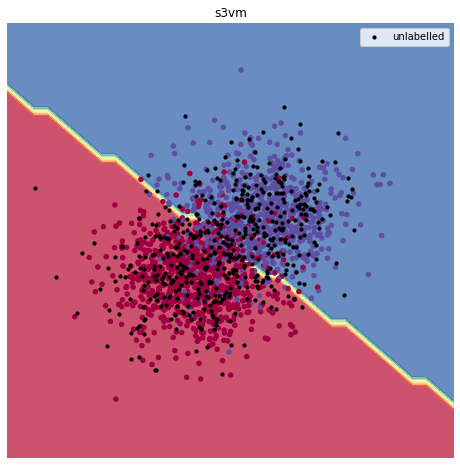

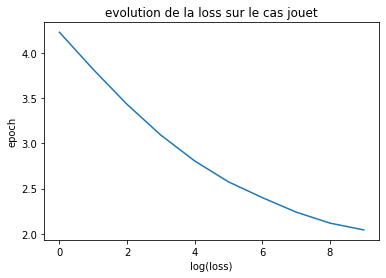

In [21]:
# paramètres
total_data = 2000
proportion = 0.75
n = int(proportion * total_data)
m = total_data - n
sigma = 0.2

# labels
y = 2 * np.random.randint(2, size=n) - 1
y_ = 2 * np.random.randint(2, size=m) - 1 # sert juste à construire x_

# observations
x = np.zeros((n, 2))
for i in range(n):
        x[i,:] = np.random.normal((y[i]+1)/2, sigma, 2)
x_ = np.zeros((m, 2))
for i in range(m):
        x_[i,:] = np.random.normal((y_[i]+1)/2, sigma, 2)

# classifieur
s3vm = S3VMClassifier()
s3vm.fit(x, y, x_)
print("accuracy sur l'ensemble jouet :", s3vm.accuracy(x, y))

# affichage
fig, ax = plt.subplots(figsize=(8,8))
plot_contours(ax, s3vm, x, y, alpha=0.8)
ax.scatter(x[:, 0], x[:, 1], c=y, s=10, cmap=plt.cm.Spectral)
ax.scatter(x_[:, 0], x_[:, 1], c='black', s=10, label='unlabelled')
ax.legend()
ax.set_title("s3vm")
plt.show()

# loss
plt.plot(np.arange(len(s3vm.loss_list)), np.log10(s3vm.loss_list))
plt.xlabel("log(loss)")
plt.ylabel("epoch")
plt.title("evolution de la loss sur le cas jouet")
plt.show()

proportion 1/50
proportion 2/50
proportion 3/50
proportion 4/50
proportion 5/50
proportion 6/50
proportion 7/50
proportion 8/50
proportion 9/50
proportion 10/50
proportion 11/50
proportion 12/50
proportion 13/50
proportion 14/50
proportion 15/50
proportion 16/50
proportion 17/50
proportion 18/50
proportion 19/50
proportion 20/50
proportion 21/50
proportion 22/50
proportion 23/50
proportion 24/50
proportion 25/50
proportion 26/50
proportion 27/50
proportion 28/50
proportion 29/50
proportion 30/50
proportion 31/50
proportion 32/50
proportion 33/50
proportion 34/50
proportion 35/50
proportion 36/50
proportion 37/50
proportion 38/50
proportion 39/50
proportion 40/50
proportion 41/50
proportion 42/50
proportion 43/50
proportion 44/50
proportion 45/50
proportion 46/50
proportion 47/50
proportion 48/50
proportion 49/50
proportion 50/50


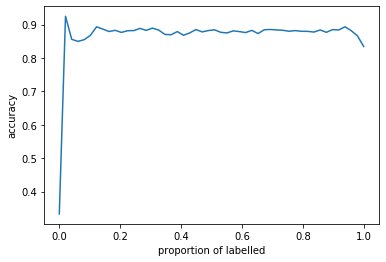

In [23]:
# très long à run (ne run que si nécessaire)

def classify_toy(proportion) :

    n = int(proportion * total_data)
    n = min(n, total_data - 2) # car il faut au moins 2 données non labelisées
    n = max(n, 2) # car il faut au moins 2 données labelisées
    m = total_data - n

    y = 2 * np.random.randint(2, size=n) - 1
    x = np.zeros((n, 2))
    for i in range(n):
            x[i,:] = np.random.normal((y[i]+1)/2, sigma, 2)
            
    y_ = 2 * np.random.randint(2, size=m) - 1
    x_ = np.zeros((m, 2))
    for i in range(m):
            x_[i,:] = np.random.normal((y_[i]+1)/2, sigma, 2)

    s3vm = S3VMClassifier()
    s3vm.fit(x, y, x_)
    return s3vm.accuracy(x, y)

total_data = 2000
sigma = 0.6
list_proportion = np.linspace(0, 1, 50)
list_accuracy = np.zeros(len(list_proportion))
for i in range(len(list_proportion)):
    print("proportion " + str(i+1) + "/" + str(len(list_proportion)))
    sum = classify_toy(list_proportion[i])
    sum += classify_toy(list_proportion[i])
    sum += classify_toy(list_proportion[i])
    list_accuracy[i] = sum/3

fig = plt.figure(figsize=(9, 5))
plt.plot(list_proportion, list_accuracy)
plt.ylabel("accuracy")
plt.xlabel("proportion of labelled")
plt.title("Evolution de l'accuracy en fonction de la proportion de données labelisées")
plt.show()

### House Data

In [20]:
s3vm = S3VMClassifier()

# s3vm.fit(vectors_train[:int(0.75 * vectors_train.shape[0]), :], 
#          newsgroups_train.target[:int(0.75 * vectors_train.shape[0])], 
#          vectors_train[int(0.75 * vectors_train.shape[0]):, :])
# print(s3vm.accuracy(vectors_test, newsgroups_test))

proportion = 0.1
nb_labelled = int(proportion * X_train.shape[0])
#s3vm.fit(X_train[:nb_labelled, :], Y_train[:nb_labelled], X_train[nb_labelled:, :], iter_gamma = 5, epochs = 3)
#print(s3vm.accuracy(X_test, Y_test))

In [ ]:
plt.plot(np.arange(len(s3vm.loss_list)), np.log10(s3vm.loss_list))
plt.show()

In [ ]:
# Y = s3vm.predict(X_test)
# print(*zip(Y.astype(int), Y_test))

In [ ]:
print(s3vm.w)
print(s3vm.b)